In [ ]:
# How many stacked exposures are required for a detection as a function of distance? 
# Simulation for on-the-ground detection

In [1]:
# Imports
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import astropy.units as u
import os
from astropy.io import fits
from astropy.table import Table, QTable
from astroduet.background import background_pixel_rate
from astroduet.config import Telescope
from astroduet.utils import duet_abmag_to_fluence, galex_to_duet
from astroduet.image_utils import construct_image, estimate_background, find, run_daophot
from astroduet.diff_image import py_zogy, calculate_diff_image
from astroduet.lightcurve import get_lightcurve, lightcurve_through_image
from astroduet.models import load_bai

# Set up Telescope and values common to all light curves
duet = Telescope()
[low_bgd_band1, low_bgd_band2] = background_pixel_rate(duet, low_zodi = True)
[med_bgd_band1, med_bgd_band2] = background_pixel_rate(duet, med_zodi = True)
[high_bgd_band1, high_bgd_band2] = background_pixel_rate(duet, high_zodi = True)
psf_fwhm_pix = duet.psf_fwhm / duet.pixel
psf_array = duet.psf_model(x_size=5,y_size=5).array

frame = np.array([30,30])
exposure = 300 * u.s
oversample = 6
pixel_size_init = duet.pixel / oversample

# Load up the Bai table
bai = QTable(load_bai())
bai['BAI1'], bai['BAI2'] = galex_to_duet([bai['SURFFUV'].value, bai['SURFNUV'].value], duet=duet)

In [2]:
# Simulations already exist in debug_dir if v3 notebook has been run. Otherwise, run v3 notebook. 

def find_check(img,psf_fwhm_pix,input_fluence):
    star_tbl, bkg_image, threshold = find(img,psf_fwhm_pix,
                                          method='daophot',background='1D',frame='diff',diag=False)
    
    try:
        result_tbl, residual = run_daophot(img,threshold,star_tbl,snr_lim=5,duet=duet,diag=False)
    except:
        print("Photometry failed!")
        residual = np.zeros(frame)
        result_tbl = Table([[0],[0],[0],[0]], names=('x_fit','y_fit','flux_fit','flux_unc'))
        return result_tbl, 0, 0, 0, residual
                        
    # Check it's the source (i.e. near center)
    found, false_pos, frac_diff = 0, 0, 0
    if len(result_tbl) > 0:
        sep = np.sqrt((result_tbl['x_fit']-(frame[0]//2))**2 + (result_tbl['y_fit']-(frame[1]//2))**2)
        closest = np.argmin(sep)
        if np.amin(sep) <= 2:
            res = result_tbl[closest]
            # Sanity check, is this close to the rate that you would expect?                     
            found_rate = res['flux_fit']
            true_rate = duet.fluence_to_rate(input_fluence).value
            frac_diff = abs(found_rate - true_rate) / true_rate
            if frac_diff > 0.8:
                false_pos = 1 
            # Even if it's a false positive, the telescope won't know
            found = 1
    
    return result_tbl, found, false_pos, frac_diff, residual

debugdir = os.path.join(os.getcwd(), 'debug_imgs')

# Load emgw and sim_details
datadir = os.path.join(os.getcwd(), '../astroduet/data')

ids, pointings, distances = [], [], []
f = open(datadir+'/emgw_random_draw.dat','r')
for line in f.readlines():
    data = line.split()
    if data[0] != 'sim:nr':
        num_pointings = np.int(data[6])
        if num_pointings <= 9: # Only simulate instances with 9 pointings or less (437 of them)
            ids.append(data[0])
            distances.append(np.float(data[3]))
            pointings.append(num_pointings)
f.close()
emgw = QTable([ids, pointings, distances * u.Mpc], names=('id', 'pointings', 'distance'))

sim_details_file = fits.open(datadir+'/emgw_40min_sim_details.fits')
sim_details = sim_details_file[1].data
sim_details_file.close()

Now running shock


/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


emgw0_40min_shock shock 89.08 Mpc False Positive
76 89.08 Mpc shock 1
      x_fit              y_fit             flux_fit          flux_unc     
                                            ph / s            ph / s      
------------------ ------------------ ----------------- ------------------
14.987274324921124 15.270363548646174 21.47319870429129 1.1902966568732904


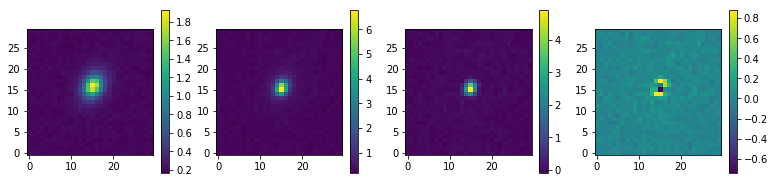

76 89.08 Mpc shock 2
      x_fit             y_fit             flux_fit          flux_unc     
                                           ph / s            ph / s      
----------------- ------------------ ----------------- ------------------
15.05849890188184 15.312700161384964 20.40107826760067 1.0629170697600483


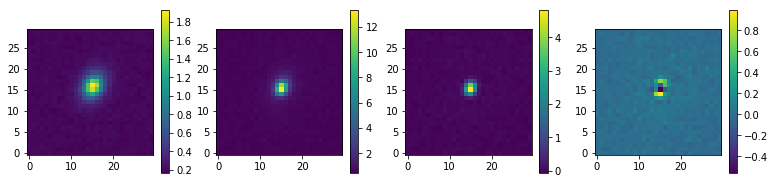

Now running blukn
emgw0_40min_blukn blukn 89.08 Mpc False Positive
76 89.08 Mpc blukn 1
      x_fit              y_fit             flux_fit           flux_unc     
                                            ph / s             ph / s      
------------------ ------------------ ------------------ ------------------
15.141161888920982 15.670308963092221 13.335305176739425 0.6659884121838586


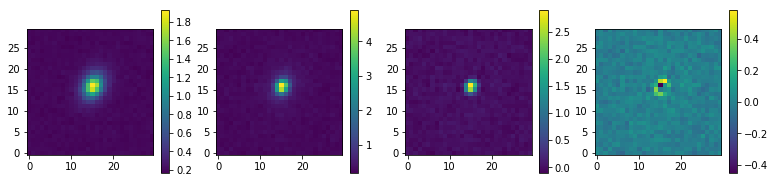

emgw0_40min_blukn blukn 89.08 Mpc False Positive
76 89.08 Mpc blukn 2
      x_fit              y_fit             flux_fit           flux_unc    
                                            ph / s             ph / s     
------------------ ------------------ ------------------ -----------------
15.148380509742184 15.686958518819928 13.706731704815137 0.665953137402343


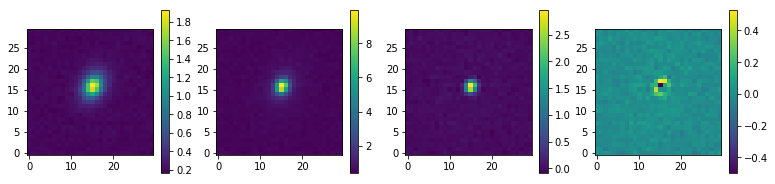

emgw0_40min_blukn blukn 89.08 Mpc False Positive
76 89.08 Mpc blukn 3
      x_fit              y_fit             flux_fit           flux_unc     
                                            ph / s             ph / s      
------------------ ------------------ ------------------ ------------------
15.148981406779104 15.683228876245737 13.722274901131334 0.6381586639959195


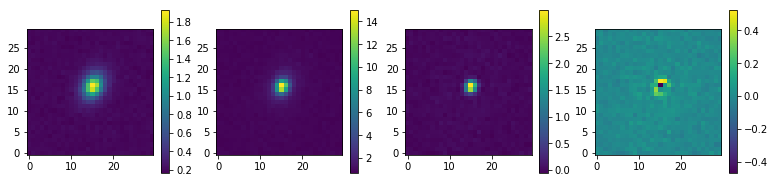

emgw0_40min_blukn blukn 89.08 Mpc False Positive
76 89.08 Mpc blukn 4
      x_fit              y_fit             flux_fit           flux_unc    
                                            ph / s             ph / s     
------------------ ------------------ ------------------ -----------------
15.137760132579649 15.676110482978611 13.556172558284054 0.618299862476585


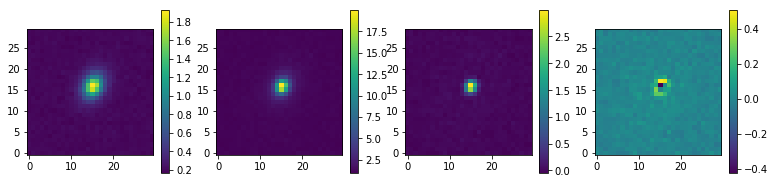

emgw0_40min_blukn blukn 89.08 Mpc False Positive
76 89.08 Mpc blukn 5
      x_fit             y_fit             flux_fit           flux_unc     
                                           ph / s             ph / s      
----------------- ------------------ ------------------ ------------------
15.14681592053763 15.679150931690879 13.653356036262442 0.6084732512234424


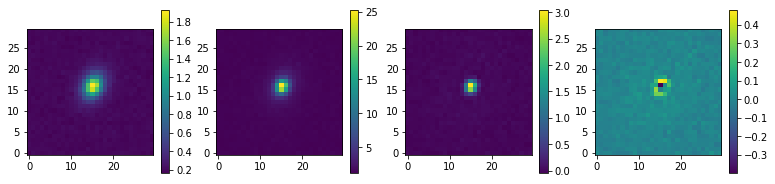

76 89.08 Mpc blukn 6
      x_fit             y_fit             flux_fit          flux_unc     
                                           ph / s            ph / s      
----------------- ------------------ ----------------- ------------------
15.14781741028816 15.681477670246508 13.55735327802461 0.6098575667179887


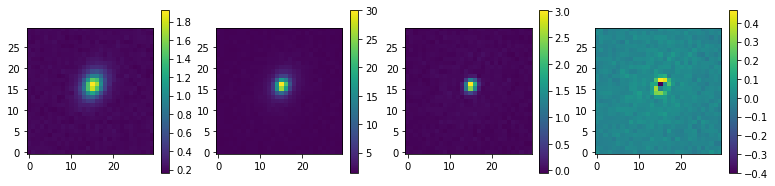

Now running shock
579 118.01 Mpc shock 1
      x_fit              y_fit             flux_fit           flux_unc     
                                            ph / s             ph / s      
------------------ ------------------ ----------------- -------------------
14.700735133756236 14.759586558061354 6.733061865210466 0.16307807301554259
13.045495578325982 20.251454063694805 6.288899100099229   0.264376964560664


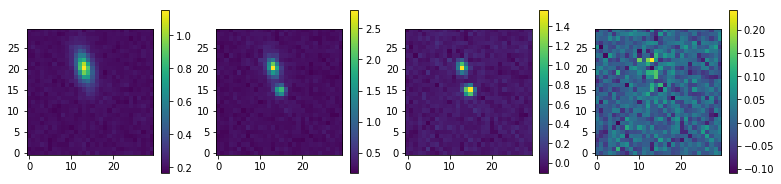

Now running blukn
579 118.01 Mpc blukn 1
      x_fit             y_fit             flux_fit            flux_unc     
                                           ph / s              ph / s      
----------------- ------------------ ------------------ -------------------
14.72139692999237 14.995183325323037 0.7735688046894174 0.09985675146564764
13.04428372386419 20.103600202586417  5.656673567926656 0.29098028063236997


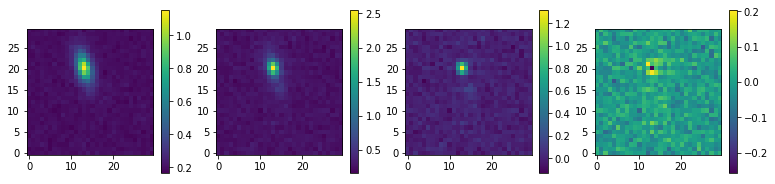

Now running shock
68 66.24 Mpc shock 1
      x_fit              y_fit             flux_fit           flux_unc     
                                            ph / s             ph / s      
------------------ ------------------ ----------------- -------------------
14.752572960955398 14.720706091236451 19.22009944699239 0.26755835069820116


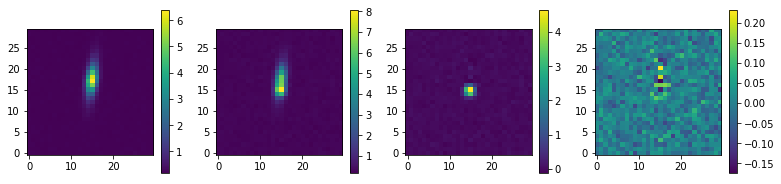

Now running blukn
68 66.24 Mpc blukn 1
      x_fit              y_fit             flux_fit           flux_unc     
                                            ph / s             ph / s      
------------------ ------------------ ------------------ ------------------
14.818686947674317 14.754763342191021 2.7954961189538134 0.2506734746945892


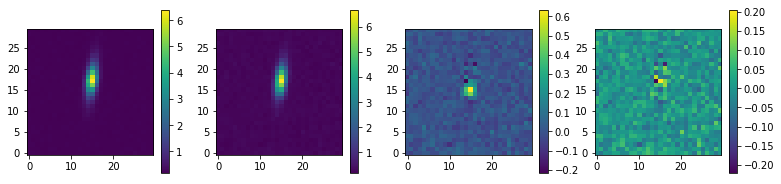

Now running shock
31 121.0 Mpc shock 1
      x_fit              y_fit            flux_fit           flux_unc     
                                           ph / s             ph / s      
------------------ ----------------- ----------------- -------------------
14.738789440697754 14.66365468164723 6.046941522875894 0.24944907665218746


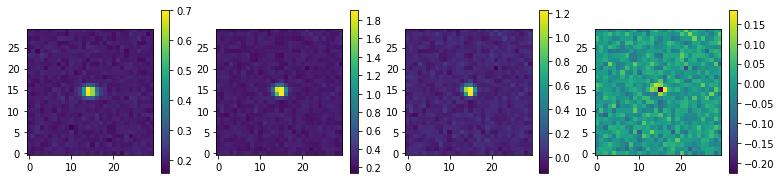

Now running blukn


KeyboardInterrupt: 

In [3]:
# For each event, loop through exposures until a source is detected, insert number into results table
results = Table(names=('id', 'pointings', 'distance', 'start_time', 'det_time', 'model', 'num_exp', 'false'), 
                dtype=('i2', 'i2', 'f8', 'i4', 'i4', 'S5', 'i2', 'i1'))

# Loop through the light curves for the events
for i, e in enumerate(emgw):
    
    distance = e['distance']
    
    # Generate reference image from galaxy stuff in sim_details
    gal = sim_details[sim_details['id'] == np.int(e['id'])]
    
    rad, theta, pos = gal['rad'], gal['theta'], gal['pos']
    rad_pix = rad / pixel_size_init
    d = pos * rad / pixel_size_init
    x_0 = d * np.cos(theta) 
    y_0 = d * np.sin(theta)
            
    gal_params = {'magnitude': gal['mag'], 'r_eff': rad_pix.value, 'n': gal['n'], 'theta': theta, \
                   'ellip': gal['ellip'], 'x_0': x_0.value, 'y_0': y_0.value}
    
    # Get correct zodi level
    if 'zodi' in gal.names:
        zodi = gal['zodi']
    else: zodi = 'low'  
    
    # Generate combined reference image for this galaxy/source setup
    nexp = 7
    if zodi == 'low':
        ref_image1 = construct_image(frame, exposure, duet=duet, band=duet.bandpass1,
                                     gal_type='custom', gal_params=gal_params, sky_rate=low_bgd_band1, n_exp=nexp)
        ref_image2 = construct_image(frame, exposure, duet=duet, band=duet.bandpass2,
                                     gal_type='custom', gal_params=gal_params, sky_rate=low_bgd_band2, n_exp=nexp)
    elif zodi == 'med':
        ref_image1 = construct_image(frame, exposure, duet=duet, band=duet.bandpass1,
                                     gal_type='custom', gal_params=gal_params, sky_rate=med_bgd_band1, n_exp=nexp)
        ref_image2 = construct_image(frame, exposure, duet=duet, band=duet.bandpass2,
                                     gal_type='custom', gal_params=gal_params, sky_rate=med_bgd_band2, n_exp=nexp)
    elif zodi == 'high':
        ref_image1 = construct_image(frame, exposure, duet=duet, band=duet.bandpass1,
                                     gal_type='custom', gal_params=gal_params, sky_rate=high_bgd_band1, n_exp=nexp)
        ref_image2 = construct_image(frame, exposure, duet=duet, band=duet.bandpass2,
                                     gal_type='custom', gal_params=gal_params, sky_rate=high_bgd_band2, n_exp=nexp)    
    total_ref_rate = (ref_image1 + ref_image2) / (exposure * nexp)
    ref_bkg, ref_bkg_rms_median = estimate_background(total_ref_rate, method='1D', sigma=2)
    ref_bkgsub = total_ref_rate - ref_bkg
    
    # Loop through different models
    for mod in ['shock','blukn']:
        
        print('Now running '+mod)

        # Grab the lightcurve files we need 
        name = 'emgw{}_40min_{}'.format(i,mod)
        table = Table.read(os.path.join(debugdir,name,name+'.hdf5'), path='default')
        
        # Loop through images, summing until we get a detection
        img_sum = np.zeros(frame) * u.ph / u.s
        num_exp, fluence_sum, detect = 0, 0, 0
        start_time, det_time = 0, 0
        for row in table:

            if row.index % e['pointings'] == 0:
                # Only add exposures that are a multiple of the number of pointings
                num_exp += 1
                false = 0
                
                # Add both bands and add them to total summed image
                img_sum += (row['imgs_D1'] + row['imgs_D2']) * u.ph / u.s

                # Convert to average rate
                img_rate = img_sum / num_exp

                # Estimate background
                img_bkg, img_bkg_rms_median = estimate_background(img_rate, method='1D', sigma=2)
                img_bkgsub = img_rate - img_bkg

                # Make difference image
                diff_image = calculate_diff_image(img_rate, img_bkgsub, total_ref_rate, ref_bkgsub)
                
                # Run Find and then DAOPhot on img_sum (DAOPhot by default only returns srcs with snr >= 5)
                fluence_sum += row['fluence_D1'] + row['fluence_D2']
                
                result_tbl, found, false_pos, frac_diff, residual = find_check(diff_image,psf_fwhm_pix.value,
                                                                               fluence_sum)
                
                if false_pos == 1: 
                    print(name, mod, distance, 'False Positive')
                    false = 1
                        
                # Source successfully found! 
                if found == 1:
                    # Record number of exposures it took, break loop
                    results.add_row((e['id'], e['pointings'], distance, start_time, row['time'], mod, num_exp, false))
                    
                    if (e['id'] == '332') & (mod == 'shock'):
                        print(e['id'], row['time'], distance, mod, num_exp)
                        
                        font = {'family':'normal','size': 14}
                        matplotlib.rc('font', **font)
                        
                        plt.figure(figsize=(15,4))
                        plt.subplot(131)
                        plt.title('Reference image')
                        plt.xlabel('DUET pixels')
                        plt.ylabel('DUET pixels')
                        plt.imshow(total_ref_rate.value, cmap='viridis', aspect=1, origin='lower')
                        plt.colorbar()
                        plt.subplot(132)
                        plt.title('Observed frame')
                        plt.imshow(img_sum.value, cmap='viridis', aspect=1, origin='lower')
                        plt.xlabel('DUET pixels')
                        plt.xlabel('DUET pixels')
                        plt.colorbar()
                        plt.subplot(133)
                        plt.title('Difference image')
                        plt.xlabel('DUET pixels')
                        plt.imshow(diff_image.value, cmap='viridis', aspect=1, origin='lower')
                        cbar = plt.colorbar()
                        cbar.set_label('DUET count rate (ct/s)')
                        plt.show()
                        
                    if (e['id'] == '175') & (mod == 'blukn'):
                        print(e['id'], row['time'], distance, mod, num_exp)
                        
                        font = {'family':'normal','size': 14}
                        matplotlib.rc('font', **font)
                        
                        plt.figure(figsize=(15,4))
                        plt.subplot(131)
                        plt.title('Reference image')
                        plt.xlabel('DUET pixels')
                        plt.ylabel('DUET pixels')
                        plt.imshow(total_ref_rate.value, cmap='viridis', aspect=1, origin='lower')
                        plt.colorbar()
                        plt.subplot(132)
                        plt.title('Observed frame')
                        plt.imshow(img_sum.value, cmap='viridis', aspect=1, origin='lower')
                        plt.xlabel('DUET pixels')
                        plt.colorbar()
                        plt.subplot(133)
                        plt.title('Difference image')
                        plt.xlabel('DUET pixels')
                        plt.imshow(diff_image.value, cmap='viridis', aspect=1, origin='lower')
                        cbar = plt.colorbar()
                        cbar.set_label('DUET count rate (ct/s)')
                        plt.show()
                    
                    if i<15:
                        print(e['id'], distance, mod, num_exp)

                        print(result_tbl['x_fit','y_fit','flux_fit','flux_unc'])
                        plt.figure(figsize=(13,3))
                        plt.subplot(141)
                        plt.imshow(total_ref_rate.value, cmap='viridis', aspect=1, origin='lower')
                        plt.colorbar()
                        plt.subplot(142)
                        plt.imshow(img_sum.value, cmap='viridis', aspect=1, origin='lower')
                        plt.colorbar()
                        plt.subplot(143)
                        plt.imshow(diff_image.value, cmap='viridis', aspect=1, origin='lower')
                        plt.colorbar()
                        plt.subplot(144)
                        plt.imshow(residual.value, cmap='viridis', aspect=1, origin='lower')
                        plt.colorbar()
                        plt.show()
                    
                    # Still continue if a false positive, we just want to record it
                    if false == 0:
                        detect = 1
                        break
                
                # We don't detect it, so flip the difference image and look for negative changes
                inv = -diff_image

                inv_tbl, found, false_pos, frac_diff, residual = find_check(inv,psf_fwhm_pix.value,-fluence_sum)
                
                if false_pos == 1: 
                    print(name, mod, distance, 'False Positive, inverse')
                    false = 1
                        
                # Source successfully found! 
                if found == 1:
                    # Record number of exposures it took, break loop
                    results.add_row((e['id'], e['pointings'], distance, start_time, row['time'], mod, num_exp, false))
                    
                    if i<15:
                        print(e['id'], distance, mod, num_exp)

                        print('(inverse)')
                        print(inv_tbl['x_fit','y_fit','flux_fit','flux_unc'])
                        plt.figure(figsize=(13,3))
                        plt.subplot(141)
                        plt.imshow(total_ref_rate.value, cmap='viridis', aspect=1, origin='lower')
                        plt.colorbar()
                        plt.subplot(142)
                        plt.imshow(img_sum.value, cmap='viridis', aspect=1, origin='lower')
                        plt.colorbar()
                        plt.subplot(143)
                        plt.imshow(inv.value, cmap='viridis', aspect=1, origin='lower')
                        plt.colorbar()
                        plt.subplot(144)
                        plt.imshow(residual.value, cmap='viridis', aspect=1, origin='lower')
                        plt.colorbar()
                        plt.show()
                    
                    if false == 0:
                        detect = 1
                        break
            
        # If source hasn't been detected record this
        if detect == 0:
            results.add_row((e['id'], e['pointings'], distance, start_time, -1, mod, -1, 0))
                
print(results)

# Write results to output
results.write('../astroduet/data/emgw_40min_results_ground.fits', format='fits', overwrite=True)

In [33]:
def collabel(rects1, rects2, labels, xpos='center'):
    """
    Attach a text label above each bar in *rects*

    *xpos* indicates which side to place the text w.r.t. the center of
    the bar. It can be one of the following {'center', 'right', 'left'}.
    """

    ha = {'center': 'center', 'right': 'left', 'left': 'right'}
    offset = {'center': 0, 'right': 1, 'left': -1}

    for i, rect1 in enumerate(rects1):
        height1 = rect1.get_height()
        height2 = rects2[i].get_height()
        height = np.maximum(height1,height2)
        plt.annotate('{}'.format(labels[i]),
                     xy=(rect1.get_x() + rect1.get_width() / 2, height),
                     xytext=(offset[xpos]*2, 2),  # use 2 points offset
                     textcoords="offset points",  # in both directions
                     ha=ha[xpos], va='bottom')

def plot_all_the_things(shock_res_strict,shock_res_lax,blukn_res_strict,blukn_res_lax):
    # What percentage were detected?
    shock_pc_strict = len(shock_res_strict[shock_res_strict['num_exp'] > -1]) / len(shock_res_strict) * 100
    blukn_pc_strict = len(blukn_res_strict[blukn_res_strict['num_exp'] > -1]) / len(blukn_res_strict) * 100

    print("Percentage detected (strict): {:.2f} % (shock), {:.2f} % (blue kilonova)".format(shock_pc_strict,blukn_pc_strict))

    shock_pc_lax = len(shock_res_lax[shock_res_lax['num_exp'] > -1]) / len(shock_res_lax) * 100
    blukn_pc_lax = len(blukn_res_lax[blukn_res_lax['num_exp'] > -1]) / len(blukn_res_lax) * 100

    print("Percentage detected (lax): {:.2f} % (shock), {:.2f} % (blue kilonova)".format(shock_pc_lax,blukn_pc_lax))

    # Plot distance vs num_exp and vs time
    plt.figure(figsize=(16,6))
    plt.subplot(121)
    plt.title('Number of exposures required for detection (strict)')
    plt.xlabel('Distance (Mpc)')
    plt.ylabel('Number of exposures')
    plt.scatter(blukn_res_strict['distance'],blukn_res_strict['num_exp'],label='blukn')
    plt.scatter(shock_res_strict['distance'],shock_res_strict['num_exp'],label='shock')
    plt.legend()
    plt.subplot(122)
    plt.title('Number of exposures required for detection (lax)')
    plt.xlabel('Distance (Mpc)')
    plt.ylabel('Number of exposures')
    plt.scatter(blukn_res_lax['distance'],blukn_res_lax['num_exp'],label='blukn')
    plt.scatter(shock_res_lax['distance'],shock_res_lax['num_exp'],label='shock')
    plt.legend()
    plt.show()

    plt.figure(figsize=(16,6))
    plt.subplot(121)
    plt.title('Time required for detection (strict)')
    plt.xlabel('Distance (Mpc)')
    plt.ylabel('Time (s)')
    plt.scatter(blukn_res_strict['distance'],blukn_res_strict['det_time'],label='blukn')
    plt.scatter(shock_res_strict['distance'],shock_res_strict['det_time'],label='shock')
    plt.legend()
    plt.subplot(122)
    plt.title('Time required for detection (lax)')
    plt.xlabel('Distance (Mpc)')
    plt.ylabel('Time (s)')
    plt.scatter(blukn_res_lax['distance'],blukn_res_lax['det_time'],label='blukn')
    plt.scatter(shock_res_lax['distance'],shock_res_lax['det_time'],label='shock')
    plt.legend()
    plt.show()

    # Detected by distance
    dists = np.arange(0,700,50)

    shock_res_binned, _ = np.histogram(shock_res_strict['distance'], bins=dists)
    shock_res_det_binned, _ = np.histogram(shock_res_strict[shock_res_strict['num_exp'] > -1]['distance'], bins=dists)
    shock_res_det_pc = np.nan_to_num(shock_res_det_binned / shock_res_binned * 100)

    blukn_res_binned, _ = np.histogram(blukn_res_strict['distance'], bins=dists)
    blukn_res_det_binned, _ = np.histogram(blukn_res_strict[blukn_res_strict['num_exp'] > -1]['distance'], bins=dists)
    blukn_res_det_pc = np.nan_to_num(blukn_res_det_binned / blukn_res_binned * 100)

    shock_res_lax_binned, _ = np.histogram(shock_res_lax['distance'], bins=dists)
    shock_res_det_lax_binned, _ = np.histogram(shock_res_lax[shock_res_lax['num_exp'] > -1]['distance'], bins=dists)
    shock_res_det_lax_pc = np.nan_to_num(shock_res_det_lax_binned / shock_res_lax_binned * 100)

    blukn_res_lax_binned, _ = np.histogram(blukn_res_lax['distance'], bins=dists)
    blukn_res_det_lax_binned, _ = np.histogram(blukn_res_lax[blukn_res_lax['num_exp'] > -1]['distance'], bins=dists)
    blukn_res_det_lax_pc = np.nan_to_num(blukn_res_det_lax_binned / blukn_res_lax_binned * 100)

    plt.figure(figsize=(15,6))
    plt.subplot(121)
    plt.title('Number detected (strict)')
    plt.xlabel('Distance (Mpc)')
    plt.ylabel('Detected')
    r2 = plt.bar(dists[1:]+10,blukn_res_det_binned,width=20,label='blukn')
    r1 = plt.bar(dists[1:]-10,shock_res_det_binned,width=20,label='shock')
    collabel(r1, r2, shock_res_binned, xpos='right')
    plt.legend()
    plt.ylim(0,80)
    plt.subplot(122)
    plt.title('Number detected (lax)')
    plt.xlabel('Distance (Mpc)')
    plt.ylabel('Detected')
    r2 = plt.bar(dists[1:]+10,blukn_res_det_lax_binned,width=20,label='blukn')
    r1 = plt.bar(dists[1:]-10,shock_res_det_lax_binned,width=20,label='shock')
    collabel(r1, r2, shock_res_binned, xpos='right')
    plt.legend()
    plt.ylim(0,80)
    plt.show()

    plt.figure(figsize=(15,6))
    plt.subplot(121)
    plt.title('Percentage detected (strict)')
    plt.xlabel('Distance (Mpc)')
    plt.ylabel('Detected (%)')
    r2 = plt.bar(dists[1:]+10,blukn_res_det_pc,width=20,label='blukn')
    r1 = plt.bar(dists[1:]-10,shock_res_det_pc,width=20,label='shock')
    collabel(r1, r2, shock_res_binned, xpos='right')
    plt.legend()
    plt.ylim(0,100)
    plt.subplot(122)
    plt.title('Percentage detected (lax)')
    plt.xlabel('Distance (Mpc)')
    plt.ylabel('Detected (%)')
    r2 = plt.bar(dists[1:]+10,blukn_res_det_lax_pc,width=20,label='blukn')
    r1 = plt.bar(dists[1:]-10,shock_res_det_lax_pc,width=20,label='shock')
    collabel(r1, r2, shock_res_binned, xpos='right')
    plt.legend()
    plt.ylim(0,100)
    plt.show()

    # Detected by number of pointings
    pointings_pl = np.arange(np.max(results['pointings']))+1

    shock_pointings = np.array([np.sum(shock_res_strict['pointings'] == p) for p in pointings_pl])
    shock_pointings_det = np.array([np.sum((shock_res_strict['pointings'] == p) & \
                                           (shock_res_strict['num_exp'] > -1)) for p in pointings_pl])
    shock_pointings_det_pc = np.nan_to_num(shock_pointings_det / shock_pointings * 100)

    blukn_pointings = np.array([np.sum(blukn_res_strict['pointings'] == p) for p in pointings_pl])
    blukn_pointings_det = np.array([np.sum((blukn_res_strict['pointings'] == p) & \
                                           (blukn_res_strict['num_exp'] > -1)) for p in pointings_pl])
    blukn_pointings_det_pc = np.nan_to_num(blukn_pointings_det / blukn_pointings * 100)

    shock_pointings_lax = np.array([np.sum(shock_res_lax['pointings'] == p) for p in pointings_pl])
    shock_pointings_lax_det = np.array([np.sum((shock_res_lax['pointings'] == p) & \
                                           (shock_res_lax['num_exp'] > -1)) for p in pointings_pl])
    shock_pointings_lax_det_pc = np.nan_to_num(shock_pointings_lax_det / shock_pointings_lax * 100)

    blukn_pointings_lax = np.array([np.sum(blukn_res_lax['pointings'] == p) for p in pointings_pl])
    blukn_pointings_lax_det = np.array([np.sum((blukn_res_lax['pointings'] == p) & \
                                           (blukn_res_lax['num_exp'] > -1)) for p in pointings_pl])
    blukn_pointings_lax_det_pc = np.nan_to_num(blukn_pointings_lax_det / blukn_pointings_lax * 100)

    plt.figure(figsize=(15,5))
    plt.subplot(121)
    plt.title('Detections by number of pointings (strict)')
    r2 = plt.bar(pointings_pl,blukn_pointings_det,label='blukn',width=0.4)
    r1 = plt.bar(pointings_pl-0.4,shock_pointings_det,label='shock',width=0.4)
    collabel(r1, r2, shock_pointings, xpos='right')
    plt.xlabel('Pointings')
    plt.ylabel('Detected')
    plt.ylim(0,180)
    plt.legend()
    plt.subplot(122)
    plt.title('Detections by number of pointings (lax)')
    r2 = plt.bar(pointings_pl,blukn_pointings_lax_det,label='blukn',width=0.4)
    r1 = plt.bar(pointings_pl-0.4,shock_pointings_lax_det,label='shock',width=0.4)
    collabel(r1, r2, shock_pointings_lax, xpos='right')
    plt.xlabel('Pointings')
    plt.ylabel('Detected')
    plt.ylim(0,180)
    plt.legend()
    plt.show()

    plt.figure(figsize=(15,5))
    plt.subplot(121)
    plt.title('Detections by number of pointings (strict)')
    r2 = plt.bar(pointings_pl,blukn_pointings_det_pc,label='blukn',width=0.4)
    r1 = plt.bar(pointings_pl-0.4,shock_pointings_det_pc,label='shock',width=0.4)
    collabel(r1, r2, shock_pointings, xpos='right')
    plt.xlabel('Pointings')
    plt.ylabel('Detected (%)')
    plt.ylim(0,100)
    plt.legend()
    plt.subplot(122)
    plt.title('Detections by number of pointings (lax)')
    r2 = plt.bar(pointings_pl,blukn_pointings_lax_det_pc,label='blukn',width=0.4)
    r1 = plt.bar(pointings_pl-0.4,shock_pointings_lax_det_pc,label='shock',width=0.4)
    collabel(r1, r2, shock_pointings_lax, xpos='right')
    plt.xlabel('Pointings')
    plt.ylabel('Detected (%)')
    plt.ylim(0,100)
    plt.legend()
    plt.show()

In [21]:
# Results for 40 mins

# Sort out results table
results_file = fits.open('../astroduet/data/emgw_40min_results_ground.fits')
results = results_file[1].data
results_file.close()

# Strict results (no false positives)
shock_res_strict_40min = results[(results['model'] == 'shock') & (results['false'] == 0)]
blukn_res_strict_40min = results[(results['model'] == 'blukn') & (results['false'] == 0)]

# More lax - including false positives (first instance thereof)
shock_res_lax_40min = Table(names=('id', 'pointings', 'distance', 'start_time', 'det_time', 'model', 'num_exp', 'false'), 
                            dtype=('i2', 'i2', 'f4', 'i4', 'i4', 'S5', 'i2', 'i1'))
blukn_res_lax_40min = Table(names=('id', 'pointings', 'distance', 'start_time', 'det_time', 'model', 'num_exp', 'false'), 
                            dtype=('i2', 'i2', 'f4', 'i4', 'i4', 'S5', 'i2', 'i1'))
for rid in np.unique(results['id']):
    rows_shock = results[(results['id'] == rid) & (results['model'] == 'shock')]
    is_det = rows_shock[rows_shock['num_exp'] > -1]
    if len(is_det) > 0:
        min_exp = is_det[is_det['num_exp'] == np.min(is_det['num_exp'])]
        shock_res_lax_40min.add_row(min_exp[0])
    else:
        shock_res_lax_40min.add_row(rows_shock[0])

    rows_blukn = results[(results['id'] == rid) & (results['model'] == 'blukn')]
    is_det = rows_blukn[rows_blukn['num_exp'] > -1]
    if len(is_det) > 0:
        min_exp = is_det[is_det['num_exp'] == np.min(is_det['num_exp'])]
        blukn_res_lax_40min.add_row(min_exp[0])
    else:
        blukn_res_lax_40min.add_row(rows_blukn[0])

RESULTS FOR 40 MIN START
For <4 pointings and distance <300 Mpc:
Shock events detected within...
2 hrs: 114/160
3 hrs: 152/160
4 hrs: 152/160
6 hrs: 152/160
Blukn events detected within...
2 hrs: 52/160
3 hrs: 86/160
4 hrs: 102/160
6 hrs: 116/160

 Overall results:
Percentage detected (strict): 83.52 % (shock), 35.01 % (blue kilonova)
Percentage detected (lax): 87.64 % (shock), 48.74 % (blue kilonova)


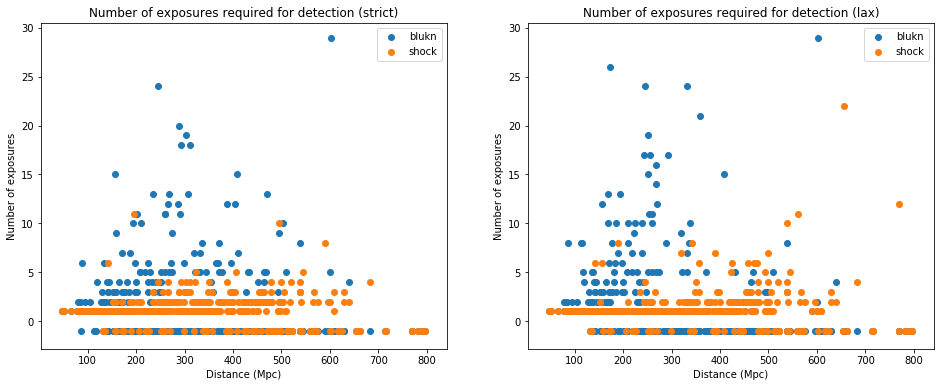

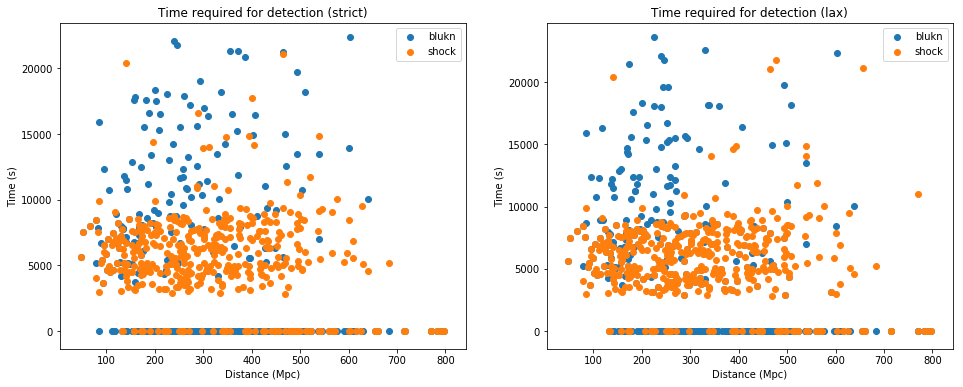

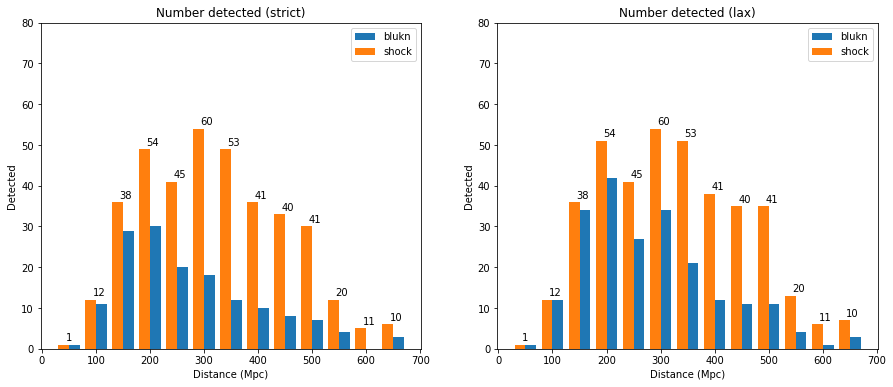

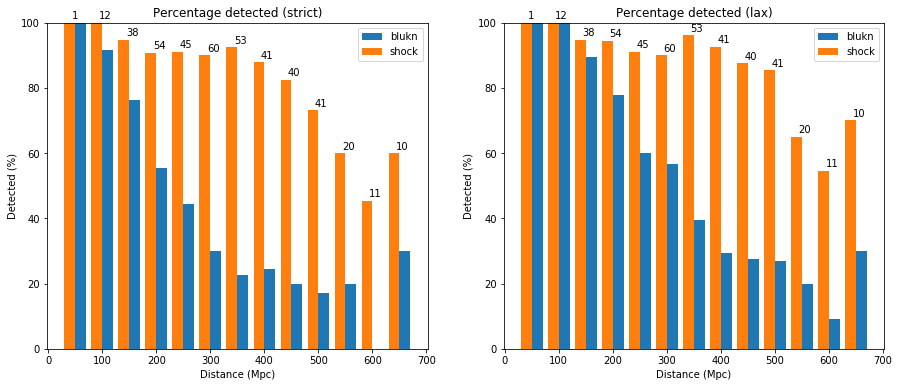

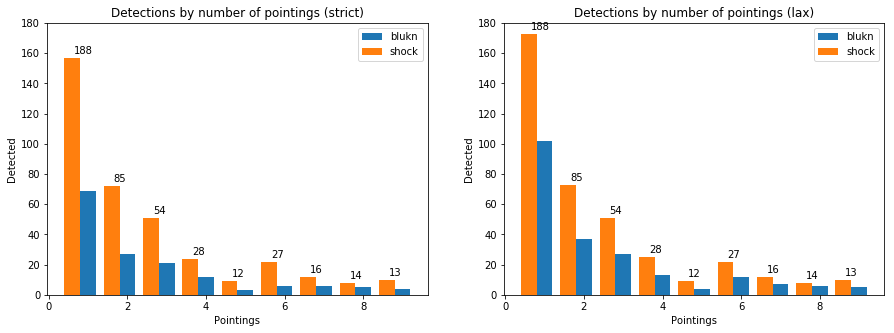

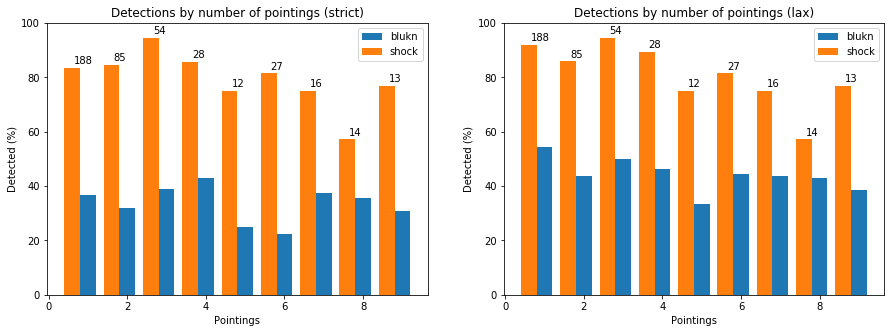

In [37]:
print('RESULTS FOR 40 MIN START')

srl = shock_res_lax_40min[(shock_res_lax_40min['pointings'] < 4) & (shock_res_lax_40min['distance'] < 300)]
brl = blukn_res_lax_40min[(blukn_res_lax_40min['pointings'] < 4) & (blukn_res_lax_40min['distance'] < 300)]

shock_time = srl['det_time'] - srl['start_time']
blukn_time = brl['det_time'] - brl['start_time']

print('For <4 pointings and distance <300 Mpc:')

print('Shock events detected within...')
print('2 hrs: {}/{}'.format(len(shock_time[(shock_time > 0) & (shock_time < 7200)]), len(srl)))
print('3 hrs: {}/{}'.format(len(shock_time[(shock_time > 0) & (shock_time < 10800)]), len(srl)))
print('4 hrs: {}/{}'.format(len(shock_time[(shock_time > 0) & (shock_time < 14400)]), len(srl)))
print('6 hrs: {}/{}'.format(len(shock_time[(shock_time > 0) & (shock_time < 21600)]), len(srl)))

print('Blukn events detected within...')
print('2 hrs: {}/{}'.format(len(blukn_time[(blukn_time > 0) & (blukn_time < 7200)]), len(brl)))
print('3 hrs: {}/{}'.format(len(blukn_time[(blukn_time > 0) & (blukn_time < 10800)]), len(brl)))
print('4 hrs: {}/{}'.format(len(blukn_time[(blukn_time > 0) & (blukn_time < 14400)]), len(brl)))
print('6 hrs: {}/{}'.format(len(blukn_time[(blukn_time > 0) & (blukn_time < 21600)]), len(brl)))

print('\n Overall results:')

plot_all_the_things(shock_res_strict_40min,shock_res_lax_40min,blukn_res_strict_40min,blukn_res_lax_40min)